In [160]:
import struct
import sys
import serial
import binascii
import time
import numpy as np
import math

import os
import datetime
import matplotlib.pyplot as plt

# Local File Imports
from parse_bin_output import *

# specify the binary file path below

import os
import time


#monitor_directory(path)

processing file: ../Industrial_Visualizer/binData/11_29_2023_21_55_54/pHistBytes_1.bin
{}


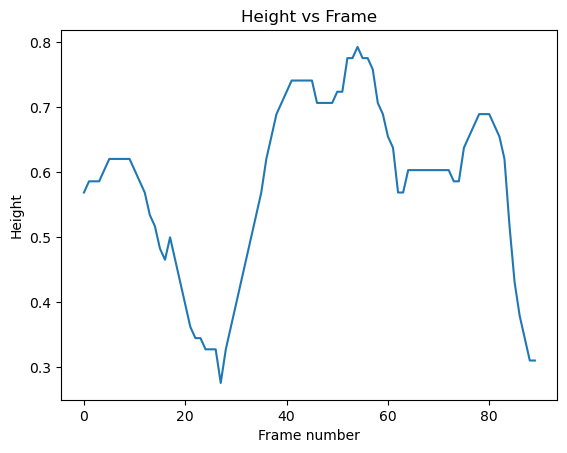

In [161]:
import scipy.signal as signal
path2 = "../Industrial_Visualizer/binData/11_29_2023_21_55_54"
output_dict = parse_ADC(path2)

#Find distances
door_height = 2.33

frame_num = 0
range_profile = output_dict[frame_num]['rangeProfile']
#plotting range profile

# define parameters to determine the range:
nFFT = len(range_profile)     # number of FFT bins
fs = 100e6 / 8                  # sampling frequency
c0 = 3e8                        # speed of light
S = 170e12                      # slope of chirp signal
sam_perd = 1/fs
num_ADC = 256
chirp_dur = sam_perd*num_ADC
bandwidth = S*chirp_dur
Dres = c0/(2*bandwidth)

dmax=(fs*c0)/(2*S)
delta_d=dmax/nFFT
# vRange represents the distance vector that will be shown in the x axes of the plot before
vRange = np.arange(nFFT) * delta_d
vRange = vRange[:len(range_profile)]

def get_distances(output_dict):
  distances = []
  for i in range(len(output_dict)):
    frame = output_dict[i]
    range_profile = frame['rangeProfile']

    peaks, _ = signal.find_peaks(range_profile, height=np.max(range_profile) * .05)
    
    if len(peaks) > 0:
        closest_peak = peaks[np.argmin(peaks)]
        # calculate distance
        vRange = np.arange(nFFT) * delta_d
        distances.append(vRange[closest_peak])

  return distances

def smooth_data(data, window_size):
  moving_avg = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
  return moving_avg

def find_heights(smoothed_data):
  highestFrame = 0
  threshold = .1477
  heights = {}
  for i in range(1, len(smoothed_data)):
    displacement = smoothed_data[i - 1] - smoothed_data[i]
    if displacement > threshold :
      if (i > highestFrame and i > (highestFrame + 1)):
        highestFrame = i
        heights[i] = door_height - smoothed_data[i]
        print("Motion is detected at Frame" + str(i) + "at distance " + str(smoothed_data[i]) + " with height " + str(door_height - smoothed_data[i]))
  return heights

plt.figure()
data = smooth_data(get_distances(output_dict), 10)
temp_dict = find_heights(data)
print(temp_dict)
plt.plot(data)
plt.xlabel('Frame number')
plt.ylabel('Height')
plt.title('Height vs Frame')
plt.show()



[-0.50791849 -0.44623483 -0.44951859 -0.38545892 -0.32830386 -0.25655922
 -0.24099525 -0.17150237 -0.07126848 -0.00247641  0.11436776  0.2131804
  0.31265245  0.40129511  0.49166347  0.58075805  0.64689509  0.71562503
  0.77440952  0.84181911  0.90001558  0.96281503  1.03026324  1.09131828
  1.13271203  1.17428327  1.22532937  1.28387173  1.28510879  1.31058006
  1.30756536  1.28227159  1.28250592  1.19472156  1.1066838   1.12413877
  1.13070005  1.14525039  1.15122857  1.15664816  1.17694507  1.20327738
  1.1816426   1.13275562  1.11234154  1.05774178  1.0257392   1.03085743
  1.0164466   1.03544379  1.02136919  0.99643197  0.96351659  0.95006487
  0.91089338  0.90605884  0.88996497  0.8340057   0.87106237  0.90771943
  0.82212716  0.71207751  0.63471908  0.55842514]


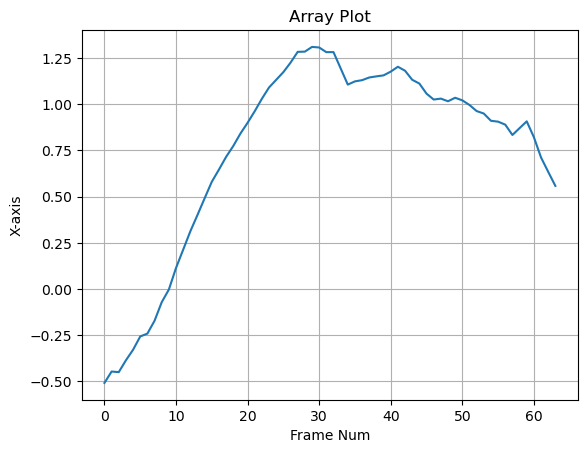

2 entered the room
1 exited the room
1 are present in the room


In [162]:
from kmeans import *
# import required libraries
import struct
import sys
import serial
import binascii
import time
import numpy as np
import math

import os
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from IPython.display import clear_output

def process_points(output_dict):
  # specify the number of clusters
    k = 2
    # specify the number of frames
    num_frames = len(output_dict)
    points = []
    for target_frame in range(num_frames):
        if 'pointCloud' in output_dict[target_frame].keys():
            xyz = output_dict[target_frame]['pointCloud'][:, 0:3]

            # xyz coordinate of detected points
            x = xyz[:, 0]
            y = xyz[:, 1]
            z = xyz[:, 2]

            kmeans = KMeans(n_clusters=1, random_state=0, n_init=10).fit(xyz)
            centroids = kmeans.cluster_centers_
                
            # Plot the point cloud
            if len(centroids[:, 0]) > 0:
                points.append(centroids[:, 0][0])
    return points

smoothed_points = smooth_data(process_points(output_dict), 10)

print(smoothed_points)
plt.plot(smoothed_points)
plt.title('Array Plot')
plt.xlabel('Frame Num')
plt.ylabel('X-axis')
plt.grid(True)
plt.show()


def calculate_inflection_points(arr):
    positive_to_negative = 0
    negative_to_positive = 0
    
    # Calculate slopes between consecutive points
    slopes = [arr[i + 7] - arr[i] for i in range(len(arr) - 7)]
    
    # Iterate through slopes to detect inflection points
    for i in range(len(slopes) - 1):
        if slopes[i] * slopes[i + 1] < 0.1:  # Detect change in slope sign
            if abs(slopes[i] - slopes[i + 1]) > 0:  # Check for significant slope change
                if slopes[i] > 0 and slopes[i + 1] < 0:
                    positive_to_negative += 1
                elif slopes[i] < 0 and slopes[i + 1] > 0:
                    negative_to_positive += 1
    
    return positive_to_negative, negative_to_positive

peeps_in, peeps_out = calculate_inflection_points(smoothed_points)

print(str(peeps_in) + " entered the room")
print(str(peeps_out) + " exited the room")
print(str(peeps_in-peeps_out) +" are present in the room")

# for i, centroid_trajectory in enumerate(centroids_data):
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     centroid_trajectory = np.array(centroid_trajectory)

#     ax.scatter(centroid_trajectory[:, 0], centroid_trajectory[:, 1], centroid_trajectory[:, 2], label=f'Centroid {i+1} trajectory')
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Z')
#     ax.legend()
#     plt.show()

In [163]:
import socket


in_peeps = 0
out_peeps = 0
ip_addr = "10.194.31.38"
port_num = 5000

sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)  # UDP
while True:
    if (in_peeps < peeps_in):
        in_peeps += 1
    sock.sendto(bytes(str(in_peeps), "utf-8"), (ip_addr, port_num))
    time.sleep(5)



In [ ]:
import tkinter as tk



#Mointor Dictionary 
def process_new_bin_data(path):
  #1 - get output dict 
  output_dict = parse_ADC(path)

  #2 - get height information









def monitor_directory(path):
  before = dict([(f, None) for f in os.listdir(path)])
  while True:
    time.sleep(1)
    after = dict([(f, None) for f in os.listdir(path)])
    added = [f for f in after if not f in before]
    if added:
      return process_new_bin_data(path+"/"+added[0])
    before = after

path = "../Industrial_Visualizer/binData"
